In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
Station.__dict__

mappingproxy({'__table__': Table('station', MetaData(), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None),
              '__module__': 'sqlalchemy.ext.automap',
              '__doc__': None,
              '_sa_class_manager': <ClassManager of <class 'sqlalchemy.ext.automap.station'> at 1456d93a0>,
              '__init__': <function sqlalchemy.orm.instrumentation.__init__(self, **kwargs)>,
              'id': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x144e06340>,
              'station': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x1457282c0>,
              'name': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x145728360>,
              'latitude': <sqlalchemy.orm.attributes.InstrumentedAttribute at

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x145789450>,
 'prcp': 0.08,
 'id': 1,
 'date': '2010-01-01',
 'tobs': 65.0,
 'station': 'USC00519397'}

# Exploratory Precipitation Analysis

In [12]:
#****** Find the most recent date in the data set.
most_recent = session.query(Measurement).order_by(desc(Measurement.date)).first()
print(most_recent.date)


2017-08-23


In [33]:
start = '2016-08-23'
meas = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
filter(Measurement.date >= start).filter(Measurement.date<= end).first()

jsonify(list(meas))

[58.0, 74.59058295964125, 87.0]

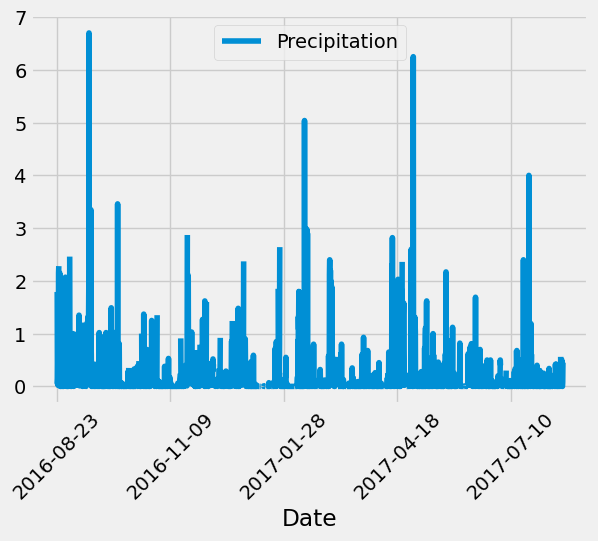

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent

# Calculate the date one year from the last date in data set.
year_ago = dt.datetime(2017, 8, 22) - dt.timedelta(days = 365)

# Perform a query to retrieve the date and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(query, columns = ['Date', 'Precipitation'])

# Sort the dataframe by date
df.sort_values('Date', inplace = True)
df
# Use Pandas Plotting with Matplotlib to plot the data
df.plot('Date', 'Precipitation', rot = 45)
plt.show()


In [51]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [53]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [73]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_ids = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).\
all()
station_ids


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [74]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
first_station = station_ids[0][0]
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == first_station).\
all()



[(54.0, 85.0, 71.66378066378067)]

In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
filter(Measurement.station == first_station).\
    filter(Measurement.date >= year_ago).\
    all()

    
temps = [result[0] for result in results]
plt.hist(temps, bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title("Last year of Temperature Frequencies at Station 'USC00519281'")
plt.show()


# Close Session

In [87]:
# Close Session
session.close()